# Fully Convolutional Neural Networks (FCN)

In this exercise, we will look how to build a network for semantic segmentation using fully convolutional neural networks.

We will not be able to do a full training at the moment, as that would require GPUs, but you can try this by running it locally later if you like.


In [ ]:
from typing import Tuple
import numpy as np
import skimage
import skimage.data
import skimage.io
import keras
import tensorflow

# for displaying images in jupyter
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

In [ ]:
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

If you want to run this on your local computer, you can check if GPU support is configured correctly in your tensorflow installation

In [ ]:
# check tensorflow installation to see if we have GPU support
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(keras.__version__)
import tensorflow

print(tensorflow.__version__)

### Images for smoke tests

When building a new network, it is a good idea to check if the network works at all, as it can sometimes take a while until all the hyper parameters are found. For that we generate a function to create some simple test images that we can use to test the network and if it is able to learn. (We will actually only use the test images in this exercise, as training on real images will take long).

For semantic segmentation, we need a label for each pixel. We will generate a noisy background image and paint a rectangle at a random position and size over the background. There will be two classes and each class will have a different mean pixel value with noise added.



In [ ]:
def gen_random_binary_test_image(height: int, width: int) -> (np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label 0 or label 1
    Label 0 images have a lower medium grayscale value, label 1 images a higher one.
    
    We will select one class for the background and then paint a rectangle over it of the other class.
    
    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to 
    images read from files
    """
    VALUE = [85, 170.0]
    CLASS_ID = [0, 1]
    NOISE = 20.0

    label = np.zeros((height, width, 1), dtype=np.uint8)
    class_id_bg = np.random.choice(CLASS_ID)
    class_id_fg = 1 - class_id_bg

    # paint background
    label.fill(class_id_bg)
    img = np.random.normal(VALUE[class_id_bg], NOISE, ((height, width, 1)))

    # start of the rectangle is in the first half
    fg_top = np.random.randint(low=0, high=height // 2)
    fg_left = np.random.randint(low=0, high=width // 2)

    # end of rectangle is in the second half
    fg_bottom = np.random.randint(low=height // 2, high=height)
    fg_right = np.random.randint(low=width // 2, high=width)

    # draw rectangle on label and image
    img[fg_top:fg_bottom, fg_left:fg_right] = np.random.normal(VALUE[class_id_fg], NOISE,
                                                               (fg_bottom - fg_top, fg_right - fg_left, 1))
    label[fg_top:fg_bottom, fg_left:fg_right] = class_id_fg

    # make sure there are no values outside
    img = np.clip(img, 0.0, 255.0).astype(np.uint8)
    return img, label

In [ ]:
image, label = gen_random_binary_test_image(64, 64)
plt.subplot(1, 2, 1)
plt.imshow(image.reshape((image.shape[0], image.shape[1])))
plt.subplot(1, 2, 2)
plt.imshow(label.reshape((image.shape[0], image.shape[1])))

### Batch of data

Training is usually done using a batch of data. For semantic segmentation, that will be a batch of images, if the images are too large they should be subdivided into smaller patches. We will also add the normalization of the data in this step. 

We will just scale the images in the range 0.0 to 1.0 from the full range of 0 to 255. Other possibilities are to scale the images individually according to their minimum and maximum values.



In [ ]:
def gen_batch_binary(batch_size, height: int, width: int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_binary_test_image(height=height, width=width)
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    label_batch = label_batch.reshape(batch_size, height, width, 1)

    return image_batch, label_batch

In [ ]:
image_batch, label_batch = gen_batch_binary(100, 128, 128)
print(image_batch.shape)
print(label_batch.shape)

## Simple FCN

We will create a simple fully convolutional neural network for processing a batch of image patches and demonstrate how to use simple down and upsampling for it.

In [ ]:
def fcn_simple_no_border(input_height: int, input_width: int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = keras.Sequential()

    # we use grayscale (1-channel input)

    # (used to define input shape on the first layers)
    model.add(keras.layers.Input(shape=(input_height, input_width, 1)))

    # Downsampling (due to strides = 2)
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))

    # Upsampling with transpose convolutions
    model.add(keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))

    # "normal" convolutional filter that preserves the size
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))

    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=1, kernel_size=1, activation=None,
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001,
                                                                                               seed=None)))
    model.add(keras.layers.Activation('sigmoid'))

    return model

In [ ]:
model = fcn_simple_no_border(128, 128)
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Lets see if the model works....

In [ ]:
history = model.fit(image_batch, label_batch, epochs=50, batch_size=10, verbose=1)

In [ ]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
# Apply it to a test image and predict a result (for each pixel)
test_img, test_label = gen_batch_binary(1, 128, 128)
pred_label = model.predict(test_img)
plt.subplot(1, 2, 1)
plt.imshow(test_label[0, :, :, :])
plt.subplot(1, 2, 2)
plt.imshow(pred_label[0, :, :, :])

## Exercise 1: Categorical data

In the example above we had only two classes, but in most applications we want to classify into more classes

Change the network and the generation of examples to use 5 classes.

We will start with the classes. Modify the generator above to select 2 out of the 5 classes for foreground and background. The mean values for those classes should be equally divided between the classes. I.e. with 3 classes you would want the levels to be at 64, 128, 192. You dont want any levels at 0 or 255 as then you can not add the noise simmetrically.

In [ ]:
def gen_random_test_image_classes(height: int, width: int, nr_classes) -> (np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label between 0 and the number of classes.


    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to
    mages read from files
    """
    # Implementation here
    step_size = 255 // (nr_classes + 1)
    VALUE = [step_size * i for i in range(1, nr_classes + 1)]
    CLASS_ID = [0, 1, 2, 3, 4]
    NOISE = 20.0

    label = np.zeros((height, width, 1), dtype=np.uint8)
    class_id_bg = np.random.choice(CLASS_ID)

    # paint background
    label.fill(class_id_bg)
    img = np.random.normal(VALUE[class_id_bg], NOISE, ((height, width, 1)))

    for class_id_fg in range(1, nr_classes):
        if class_id_fg == class_id_bg:
            continue
        # start of the rectangle is in the first half
        fg_top = np.random.randint(low=0, high=height // 2)
        fg_left = np.random.randint(low=0, high=width // 2)

        # end of rectangle is in the second half
        fg_bottom = np.random.randint(low=height // 2, high=height)
        fg_right = np.random.randint(low=width // 2, high=width)

        # draw rectangle on label and image
        img[fg_top:fg_bottom, fg_left:fg_right] = np.random.normal(VALUE[class_id_fg], NOISE,
                                                                   (fg_bottom - fg_top, fg_right - fg_left, 1))
        label[fg_top:fg_bottom, fg_left:fg_right] = class_id_fg

    # make sure there are no values outside
    img = np.clip(img, 0.0, 255.0).astype(np.uint8)
    return img, label



In [ ]:
image, label = gen_random_test_image_classes(64, 64, 5)
np.testing.assert_array_equal(image.shape, (64, 64, 1))
np.testing.assert_array_equal(label.shape, (64, 64, 1))
plt.subplot(1, 2, 1)
plt.imshow(image.reshape((image.shape[0], image.shape[1])))
plt.subplot(1, 2, 2)
plt.imshow(label.reshape((image.shape[0], image.shape[1])), vmax=5)
print(image.dtype)

We again add a function that generates a batch of images.

In [ ]:
def gen_batch_image_classes(batch_size, height: int, width: int, nr_classes: int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_test_image_classes(height=height, width=width, nr_classes=nr_classes)
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    # label_batch = label_batch.reshape(batch_size, (height-2*border)*(width-2*border), 1)
    label_batch = keras.utils.to_categorical(label_batch, num_classes=nr_classes)

    return image_batch, label_batch

Often it is not possible to load an entire dataset into memory and train it all from there. One solution it to use a so called generator that will provide data that can for example be read from files. We will simulate a generator here, that will just continously generate new data.

In [ ]:
# Generator
def batch_generator_image_classes(batch_size, height: int, width: int, nr_classes: int):
    while True:
        image_batch, label_batch = gen_batch_image_classes(batch_size=batch_size,
                                                           height=height, width=width,
                                                           nr_classes=nr_classes)
        yield image_batch, label_batch

## Exercise 2: Network to process categorical data

Now we need to generate a new model that can deal with categorical data. What needs to be changed?

In [ ]:
def fcn_multiple_classes(input_height: int, input_width: int, nr_classes: int) -> (keras.Model, int):
    """
    Create a simple fcn model for semantic segmentation with the indicated number of  classes.
    """
    model = keras.Sequential()

    # we use grayscale (1-channel input)

    # (used to define input shape on the first layers)
    model.add(keras.layers.Input(shape=(input_height, input_width, 1)))

    # Downsampling (due to strides = 2)
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))

    # Upsampling with transpose convolutions
    model.add(keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))

    # "normal" convolutional filter that preserves the size
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))

    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=nr_classes, kernel_size=1, activation=None,
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001,
                                                                                               seed=None)))
    model.add(keras.layers.Activation('softmax'))

    return model

In [ ]:
model = fcn_multiple_classes(128, 128, 5)
model.summary()
assert model is not None

Next we need to compile the model. What needs to be changed from the previous 2 class model? 


In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

### Exercise 3: Train the model

Now train the model using the batch generator and save the result in history. You should be able to recieve an accuracy of 0.99 or better on this data.

In [ ]:
history = None

PATCH_HEIGHT = 64
PATCH_WIDTH = 64
BATCH_SIZE = 128
EPOCHS = 5
NR_CLASSES = 5
STEPS_PER_EPOCH = 100
image_batch, label_batch = gen_batch_image_classes(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH, NR_CLASSES)
model = fcn_multiple_classes(PATCH_HEIGHT, PATCH_WIDTH, NR_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    batch_generator_image_classes(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH, NR_CLASSES),
    epochs=EPOCHS,
    verbose=1,
    steps_per_epoch=STEPS_PER_EPOCH,
    shuffle=False,
    callbacks=None)


In [ ]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


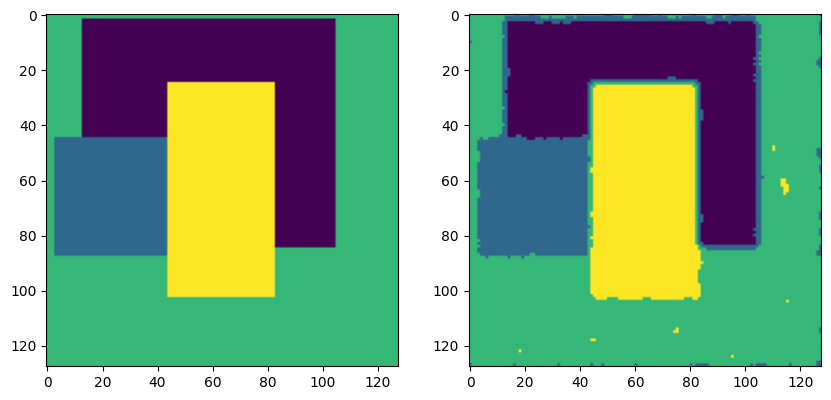

In [118]:
# Apply it to a test image and predict a result (for each pixel)
test_img, test_label = gen_batch_image_classes(1, 128, 128,5)
pred_label = model.predict(test_img)
plt.subplot(1, 2, 1)
plt.imshow(np.argmax(test_label[0, :, :, :], axis=-1))
plt.subplot(1, 2, 2)
plt.imshow(np.argmax(pred_label[0, :, :, :], axis=-1))

In [119]:
assert history.history['accuracy'][-1] > 0.9

AssertionError: 